# Simple PINN for an elastic plate with an elliptical hole 

## Geometry

We want to model a quarter of a plate with an elliptical hole. The domain itself is represented by collocation points, the boundaries are represented by uniformly sampled points along the perimeter.

In [331]:
import torch
from torch.optim.lr_scheduler import StepLR, ExponentialLR
import numpy as np
from scipy.stats import qmc
from plotly.express.colors import sequential
import plotly.graph_objects as go
import plotly.figure_factory as ff
from tqdm import tqdm
import matplotlib.pyplot as plt

torch.set_default_dtype(torch.float64)
from global_constants import L, R, MU, LBD, N1, N2

# Elliptical axis in x direction
Rx = 0.14
# Elliptical axis in y direction
Ry = R**2 / Rx
# Number of points for one boundary 
N = 25
# Number of collocation points
collo_number = 500

# Number of hidden neurons
hn = 50

# Weight of PDE loss
W_PDE = 0.00001 #previous value -> 0.001
# Weight of Neumann loss
W_NEU = 0.0005 #previous value -> 0.05 
# Weight of data losses
W_STRESS = 0.0
W_DISP = 0.0


# Load reference data
data_input = torch.as_tensor(
    np.loadtxt(f"data/inputs_Rx={Rx}.csv", delimiter=","), dtype=torch.float64
)
data_output = torch.as_tensor(
    np.loadtxt(f"data/outputs_Rx={Rx}.csv", delimiter=","), dtype=torch.float64
)

# Create collocation points
points = L * qmc.LatinHypercube(d=2).random(N**4)
mask = (((points[:, 0] ** 2) / (Rx**2)) + ((points[:, 1] ** 2) / (Ry**2))) > 1
valid_points = points[mask]
density = 1 / (valid_points[:,0]**2 / Rx**2 + valid_points[:,1]**2 / Ry**2)
selected_points = np.random.choice(len(valid_points[:,0]), size= collo_number, replace= False,  p = density / np.sum(density))
collocation = torch.tensor(valid_points[selected_points], requires_grad=True).double()

# #additional collocation points
# border = 0.2 * L * qmc.LatinHypercube(d=2).random(N**2)
# upperRy = Ry + 0.05
# upperRx = Rx + 0.05
# bordermask = (((border[:, 0] ** 2) / (upperRx**2)) + ((border[:, 1] ** 2) / (upperRy**2))) < 1
# bordermask2 = ((((border[bordermask][:, 0] ** 2) / (Rx**2)) + ((border[bordermask][:, 1] ** 2) / (Ry**2))) > 1)
# bordermask3 = (border[bordermask][bordermask2][:, 0] <  0.20)
# #bordermask4 = (border[bordermask][bordermask2][bordermask3][:, 1] <  0.95)
# addi_collo = torch.tensor(border[bordermask][bordermask2][bordermask3], requires_grad=True).double()
# complete_collo = torch.cat((collocation, addi_collo), 0)

# Boundary points
x_top = torch.linspace(0, L, N, requires_grad=True).double()
y_top = L * torch.ones((N, 1), requires_grad=True).double()
top = torch.column_stack([x_top, y_top]).double()

NN = int(N * (L - Rx) / L)
x_bottom = torch.linspace(Rx, L, NN).double()
y_bottom = torch.zeros((NN, 1)).double()
bottom = torch.column_stack([x_bottom, y_bottom]).double()

NN = int(N * (L - Ry) / L)
x_left = torch.zeros((NN, 1)).double()
y_left = torch.linspace(Ry, L, NN).double()
left = torch.column_stack([x_left, y_left]).double()

x_right = L * torch.ones((N, 1)).double()
y_right = torch.linspace(0, L, N).double()
right = torch.column_stack([x_right, y_right]).double()

phi = np.linspace(0, 0.5 * np.pi, int(N * np.pi * Rx / L))
x_hole = torch.tensor(Rx * np.cos(phi), requires_grad=True).double()
y_hole = torch.tensor(Ry * np.sin(phi), requires_grad=True).double()
n_hole = torch.tensor(np.stack([-Ry * np.cos(phi), -Rx * np.sin(phi)]).T).double()
n_hole = n_hole / torch.linalg.norm(n_hole, axis=1)[:, None]
hole = torch.column_stack([x_hole, y_hole]).double()

# Visualize geometry
with torch.no_grad():
    mode = "markers"
    gray = dict(color="#C9C5BC")
    green = dict(color="#006561")
    black = dict(color="black")
    fig = ff.create_quiver(hole[:, 0], hole[:, 1], n_hole[:, 0], n_hole[:, 1], marker=black)
    fig.add_trace(go.Scatter(x=collocation[:, 0], y=collocation[:, 1], mode=mode, marker=gray))
    fig.add_trace(go.Scatter(x=top[:, 0], y=top[:, 1], mode=mode, marker=green))
    fig.add_trace(go.Scatter(x=bottom[:, 0], y=bottom[:, 1], mode=mode, marker=green))
    fig.add_trace(go.Scatter(x=left[:, 0], y=left[:, 1], mode=mode, marker=green))
    fig.add_trace(go.Scatter(x=right[:, 0], y=right[:, 1], mode=mode, marker=green))
    fig.add_trace(go.Scatter(x=hole[:, 0], y=hole[:, 1], mode=mode, marker=black))
    fig.layout.yaxis.scaleanchor = "x"
    fig.update_layout(
        template="none",
        width=400,
        height=400,
        margin=dict(l=0, r=0, b=0, t=0),
        showlegend=False,
    )
    fig.update_xaxes(visible=False)
    fig.update_yaxes(visible=False)
    fig.show()

## The ANN model that approximates the displacement field

An ANN might be considered as a generic function approximator. In this case, it should approximated the function $u: \mathcal{R}^2 \rightarrow \mathcal{R}^2$ with five hidden layers having 20 neurons each.

In [332]:
class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.hidden_layer1 = torch.nn.Linear(2, hn)
        self.hidden_layer2 = torch.nn.Linear(hn, hn)
        self.hidden_layer3 = torch.nn.Linear(hn, hn)
        self.hidden_layer4 = torch.nn.Linear(hn, hn)
        self.hidden_layer5 = torch.nn.Linear(hn, hn)
        self.output_layer = torch.nn.Linear(hn, 2)

    def forward(self, inputs):
        layer1_out = torch.tanh(self.hidden_layer1(inputs))
        layer2_out = torch.tanh(self.hidden_layer2(layer1_out))
        layer3_out = torch.tanh(self.hidden_layer3(layer2_out))
        layer4_out = torch.tanh(self.hidden_layer4(layer3_out))
        layer5_out = torch.tanh(self.hidden_layer5(layer4_out))
        output = self.output_layer(layer5_out)
        return output

#reset all network parameters    
def weight_reset(m):
    reset_parameters = getattr(m, "reset_parameters", None)
    if callable(reset_parameters):
        m.reset_parameters()





net = Net()

## The physics

We want to solve linear elasticity on the domain, which means ultimately that we want to minimize the residual of the following PDE 
$$\frac{\partial \sigma_{11}}{\partial x_1} + \frac{\partial \sigma_{12}}{\partial x_2} - b_1 = 0$$
$$\frac{\partial \sigma_{21}}{\partial x_1} + \frac{\partial \sigma_{22}}{\partial x_2} - b_2 = 0$$
with stress 
$$ \sigma_{ij} = 2\mu \varepsilon_{ij} + \lambda \varepsilon_{kk} \delta_{ij} $$
and strain 
$$ \varepsilon_{ij} = \frac{1}{2} \left( \frac{\partial u_i}{\partial x_j} +  \frac{\partial u_j}{\partial x_i}\right).$$

In [333]:
def epsilon(x):
    # Compute deformation gradient
    dudx = torch.func.jacrev(net)(x)
    return 0.5 * (dudx + dudx.T)

def sigma(x):
    # Compute (small deformation) strain
    eps = epsilon(x)
    # Compute linear elastic strain (assuming plane stress)
    return 2.0 * MU * eps + (2*LBD*MU)/(2*MU+LBD) * torch.trace(eps) * torch.eye(2)


def pde_residual(x):
    # Compute stress gradient
    dsdx = torch.func.jacrev(sigma)(x)
    # Momentum balance in x direction
    residual_x = dsdx[0, 0, 0] + dsdx[0, 1, 1] 
    # Momentum balance in y direction
    residual_y = dsdx[1, 0, 0] + dsdx[1, 1, 1]
    return residual_x, residual_y

## Boundary conditions

Left: 

$$ u_1 = 0$$

Bottom: 

$$ u_2 = 0$$

Top: 

$$ \sigma \cdot n = N_2 n$$

Right: 

$$ \sigma \cdot n = N_1 n$$

In [334]:
mse = torch.nn.MSELoss()


def compute_physics_losses(complete_collo):
    # pde
    res_x, res_y = torch.vmap(pde_residual)(complete_collo)
    zeros = torch.zeros_like(res_x)
    pde_error = mse((res_x), zeros) + mse((res_y), zeros)

    # left boundary
    pred_left = net(left)
    bc_left = torch.zeros_like(pred_left[:, 0])
    left_error = mse(pred_left[:, 0], bc_left)

    # bottom boundary
    pred_bottom = net(bottom)
    bc_bottom = torch.zeros_like(pred_bottom[:, 1])
    bottom_error = mse(pred_bottom[:, 1], bc_bottom)

    # top boundary
    pred_stress_top = torch.vmap(sigma)(top)
    pred_s_top_yy = pred_stress_top[:,1,1]
    pred_s_top_xy = pred_stress_top[:,0,1]
    s_top_yy = N2*torch.ones_like(pred_s_top_yy)
    s_top_xy = torch.zeros_like(pred_s_top_xy)
    top_error = mse(pred_s_top_yy, s_top_yy) + mse(pred_s_top_xy, s_top_xy)

    # right boundary
    pred_stress_right = torch.vmap(sigma)(right)
    pred_s_right_xx = pred_stress_right[:,0,0]
    pred_s_right_xy = pred_stress_right[:,1,0]
    s_right_xx = N1*torch.ones_like(pred_s_right_xx)
    s_right_xy = torch.zeros_like(pred_s_right_xy)
    right_error = mse(pred_s_right_xx, s_right_xx) + mse(pred_s_right_xy, s_right_xy)


    # hole boundary
    stress_hole = torch.vmap(sigma)(hole)
    traction = torch.einsum("...ij,...j->...i", stress_hole, n_hole)
    zeros = torch.zeros_like(traction[:, 0])
    hole_error = mse(traction[:, 0], zeros) + mse(traction[:, 1], zeros)


    return (left_error, right_error, bottom_error, top_error, hole_error, pde_error)

## Training 

In [335]:
# Epochs
epochs_adam = 3000 #2.5-3it/s -> 7min #previous value -> 5600
epochs_lbfgs = 0 
# Batch size
batch_size = 64
# Learning rate
lr = 0.005 #previous value -> 0.005
# Scheduler step width
scheduler_step = 400
# Gamma factor of scheduler
scheduler_gamma = 0.7 # #previous value -> 0.6-0.8 or 0.55
exponential_gamma = 0.995 #previous value -> 0.9994162117


history = []
testruns = 30 #total amount of test runs
test = 1 #have to be 1
# Weight_PDE = 1e-05 #previous value -> 0.00001
# Weight_NEU = 5e-05 #previous value -> 0.0001
W_PDE = 0.001
# Weight of Neumann loss
W_NEU = 0.05
Weight_PDE = 8.0e-06 #previous value -> 0.00005
Weight_NEU = 7.999999999999999e-05 #previous value -> 0.0001

stressError = torch.tensor(19) #previous value 
#describes new weight = weight*factor for each step
#if(Error > previous Error ) -> factor = 1/factor
factor = 5
token = 0 #changes weight_case if token will be changed twice
weight_case = 1 #0->PDE; 1->NEU; 2->PDE and NEU; 3->no weight changes

data_hole = np.loadtxt(f"data/hole_Rx={Rx}.csv", delimiter=",")
data_hole = data_hole[data_hole[:, 0].argsort()]
data_stress_x = data_hole[:, 2]
data_stress_y = data_hole[:, 3]


#generate poly func that fits data_stress_x and data_stress_y
x_stress_func = np.polyfit(data_hole[:, 0], data_hole[:, 2], 6)
y_stress_func = np.polyfit(data_hole[:, 0], data_hole[:, 3], 6)
f_stress_x = np.poly1d(x_stress_func)
f_stress_y = np.poly1d(y_stress_func)
x_new = np.linspace(hole[0, 0].item(), hole[-1, 0].item(), hole[:, 0].size(dim=0))
y_stress_x = f_stress_x(x_new)
y_stress_y = f_stress_y(x_new)

# Weight_NEU und Weight_PDE als PyTorch nn parameter 
Weight_NEU = torch.nn.Parameter(torch.tensor(1.0), requires_grad=True)
Weight_PDE = torch.nn.Parameter(torch.tensor(1.0), requires_grad=True)

#optimizer with parameter of nn and weights for optimization
optimizer = torch.optim.Adam(list(net.parameters()) + [Weight_NEU, Weight_PDE], lr=lr)

scheduler = ExponentialLR(optimizer, gamma=exponential_gamma)
for epoch in tqdm(range(epochs_adam)):
    # Permutation to shuffle collocation points randomly in each epoch
    permutation = torch.randperm(collocation.size()[0])

    for i in range(0, collocation.size()[0], batch_size):
        indices = permutation[i : i + batch_size]
        collo = collocation[indices]
        optimizer.zero_grad()

        # Compute physics losses
        left_l, right_l, bottom_l, top_l, hole_l, pde_l = compute_physics_losses(collo)

        if W_DISP < 1E-10 and W_STRESS < 1E-10:
            # No data losses needed (we can accelerate training by skipping this part)
            stress_l = 0.0
            disp_l = 0.0
        else:
            # Get samples from reference solution
            samples = torch.randperm(data_output.size()[0])[::100]
            # Reference solutions
            s_data = data_output[samples, 0:3]
            e_data = data_output[samples, 4:7]
            u_data = data_output[samples, 7:10]
            # Predictions
            s_pred = torch.vmap(sigma)(data_input[samples, 0:2])
            e_pred = torch.vmap(epsilon)(data_input[samples, 0:2])
            u_pred = net(data_input[samples, 0:2])
            # Compute data losses
            ds_xx = mse(s_data[:, 0], s_pred[:, 0, 0])
            ds_yy = mse(s_data[:, 1], s_pred[:, 1, 1])
            ds_xy = mse(s_data[:, 2], s_pred[:, 0, 1])
            stress_l = ds_xx + ds_yy + ds_xy
            du_x = mse(u_data[:, 0], u_pred[:, 0])
            du_y = mse(u_data[:, 1], u_pred[:, 1])
            disp_l = du_x + du_y

        # Aggregate losses
        dirichlet_losses = left_l + bottom_l 
        neumann_losses = right_l + top_l + hole_l


        loss = (
            dirichlet_losses
            + Weight_NEU * neumann_losses
            + Weight_PDE * pde_l
            + W_STRESS * stress_l
            + W_DISP * disp_l
        )

        # Make optimization step after batch
        loss.backward(retain_graph=True)
        optimizer.step()

    # Make scheduler step after full epoch
    scheduler.step()

    # Fügen Sie den Verlust zur Historie hinzu (= zum Plotten)
    with torch.autograd.no_grad():
        history.append(float(loss.data))
        # Vergleichen Sie den berechneten Stressfehler mit der tatsächlichen Stressfunktion
        stress_hole = torch.vmap(sigma)(hole)
        stressError = mse(stress_hole[:, 0, 0], torch.tensor(y_stress_x)) + mse(stress_hole[:, 1, 1], torch.tensor(y_stress_y))

    # Geben Sie die Gewichte und den Stressfehler alle 200 Epochen aus
    if epoch % 200 == 0:
        print(f"Epoch: {epoch}, Weight_NEU: {Weight_NEU.item()}, Weight_PDE: {Weight_PDE.item()}, Stress Error: {stressError.item()}")


  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 1/3000 [00:28<23:27:21, 28.16s/it]

Epoch: 0, Weight_NEU: 0.9691040207515593, Weight_PDE: 0.9684978430798227, Stress Error: 9.262096011385562


  0%|          | 4/3000 [01:48<22:21:03, 26.86s/it]

In [ ]:
# Epochs
epochs_adam = 3000 #2.5-3it/s -> 7min #previous value -> 5600
epochs_lbfgs = 0 
# Batch size
batch_size = 64
# Learning rate
lr = 0.005 #previous value -> 0.005
# Scheduler step width
scheduler_step = 400
# Gamma factor of scheduler
scheduler_gamma = 0.7 # #previous value -> 0.6-0.8 or 0.55
exponential_gamma = 0.995 #previous value -> 0.9994162117


history = []
testruns = 30 #total amount of test runs
test = 1 #have to be 1
# Weight_PDE = 1e-05 #previous value -> 0.00001
# Weight_NEU = 5e-05 #previous value -> 0.0001
W_PDE = 0.001
# Weight of Neumann loss
W_NEU = 0.05
Weight_PDE = 8.0e-06 #previous value -> 0.00005
Weight_NEU = 7.999999999999999e-05 #previous value -> 0.0001

stressError = torch.tensor(19) #previous value 
#describes new weight = weight*factor for each step
#if(Error > previous Error ) -> factor = 1/factor
factor = 5
token = 0 #changes weight_case if token will be changed twice
weight_case = 1 #0->PDE; 1->NEU; 2->PDE and NEU; 3->no weight changes

data_hole = np.loadtxt(f"data/hole_Rx={Rx}.csv", delimiter=",")
data_hole = data_hole[data_hole[:, 0].argsort()]
data_stress_x = data_hole[:, 2]
data_stress_y = data_hole[:, 3]


#generate poly func that fits data_stress_x and data_stress_y
x_stress_func = np.polyfit(data_hole[:, 0], data_hole[:, 2], 6)
y_stress_func = np.polyfit(data_hole[:, 0], data_hole[:, 3], 6)
f_stress_x = np.poly1d(x_stress_func)
f_stress_y = np.poly1d(y_stress_func)
x_new = np.linspace(hole[0, 0].item(), hole[-1, 0].item(), hole[:, 0].size(dim=0))
y_stress_x = f_stress_x(x_new)
y_stress_y = f_stress_y(x_new)

# # plot the stress function of the hole
# plt.plot(x_new, y_stress_x, 'o')
# plt.plot(x_new, y_stress_y, 'o')
# plt.show()




def optimize_weights():
    Weight_NEU = torch.tensor(1.0, requires_grad=True)  # initial Weight_NEU
    Weight_PDE = torch.tensor(1.0, requires_grad=True)  # initial Weight_PDE
    
    print("Starting with Adam optimizer run " +str(test) +" with epochs: " + str(epochs_adam) + "; exponential gamma: " + str(exponential_gamma) + "; lr = " +str(lr))
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    #scheduler = StepLR(optimizer, step_size=scheduler_step, gamma=scheduler_gamma)
    scheduler = ExponentialLR(optimizer, gamma=exponential_gamma) #gamma value for 5600 epochs -> lr 1.9e-04 in epoch 5600 = equal to StepLR(800steps, gamma=0.6267753995)
    for epoch in tqdm(range(epochs_adam)):
        # Permutation to shuffle collocation points randomly in each epoch
        permutation = torch.randperm(collocation.size()[0])

        for i in range(0, collocation.size()[0], batch_size):
            indices = permutation[i : i + batch_size]
            collo = collocation[indices]
            optimizer.zero_grad()

            # Compute physics losses
            left_l, right_l, bottom_l, top_l, hole_l, pde_l = compute_physics_losses(collo)

            if W_DISP < 1E-10 and W_STRESS < 1E-10:
                # No data losses needed (we can accelerate training by skipping this part)
                stress_l = 0.0
                disp_l = 0.0
            else:
                # Get samples from reference solution
                samples = torch.randperm(data_output.size()[0])[::100]
                # Reference solutions
                s_data = data_output[samples, 0:3]
                e_data = data_output[samples, 4:7]
                u_data = data_output[samples, 7:10]
                # Predictions
                s_pred = torch.vmap(sigma)(data_input[samples, 0:2])
                e_pred = torch.vmap(epsilon)(data_input[samples, 0:2])
                u_pred = net(data_input[samples, 0:2])
                # Compute data losses
                ds_xx = mse(s_data[:, 0], s_pred[:, 0, 0])
                ds_yy = mse(s_data[:, 1], s_pred[:, 1, 1])
                ds_xy = mse(s_data[:, 2], s_pred[:, 0, 1])
                stress_l = ds_xx + ds_yy + ds_xy
                du_x = mse(u_data[:, 0], u_pred[:, 0])
                du_y = mse(u_data[:, 1], u_pred[:, 1])
                disp_l = du_x + du_y

            # Aggregate losses
            dirichlet_losses = left_l + bottom_l 
            neumann_losses = right_l + top_l + hole_l


            loss = (
                dirichlet_losses
                + Weight_NEU * neumann_losses
                + Weight_PDE * pde_l
                + W_STRESS * stress_l
                + W_DISP * disp_l
            )

            # Make optimization step after batch
            loss.backward(retain_graph=True)
            optimizer.step()

        # Make scheduler step after full epoch
        scheduler.step()
        
        # append loss to history (=for plotting)
        with torch.autograd.no_grad():
            history.append(float(loss.data))
            #compare calculated stress error with actual stress_function
            stress_hole = torch.vmap(sigma)(hole)
            stressError = mse(stress_hole[:, 0, 0], torch.tensor(y_stress_x)) + mse(stress_hole[:, 1, 1], torch.tensor(y_stress_y))

        #calculate gradients 
        grad_NEU = torch.autograd.grad(loss, Weight_NEU, retain_graph= True)[0]
        grad_PDE = torch.autograd.grad(loss, Weight_PDE, retain_graph= True)[0]
        #grad_stressError = torch.autograd.grad(loss, stressError, retain_graph= True)[0]

        # compute new Weight_NEU 
        new_Weight_NEU= Weight_NEU
        Weight_NEU =  new_Weight_NEU - 0.01 * grad_NEU
        new_Weight_PDE= Weight_PDE
        Weight_PDE =  new_Weight_PDE - 0.01 * grad_PDE

        # new_Weight_NEU= Weight_NEU
        # Weight_NEU =  new_Weight_NEU - 0.01 * grad_stressError
        # new_Weight_PDE= Weight_PDE
        # Weight_PDE =  new_Weight_PDE - 0.01 * grad_stressError


        # new_weights and stressError
        if epoch % 200 == 0:
            print(f"Epoch: {epoch}, Weight_NEU: {Weight_NEU.item()}, Weight_PDE: {Weight_PDE.item()}, Stress Error: {stressError.item()}")
            print(type(stressError))
    print("after ADAM the weight for PDE is ", Weight_PDE)
    print("after ADAM the weight for NEUMANN is ", Weight_NEU)
    print("after ADAM current_x_stressError is", stressError.item())
    return Weight_NEU, Weight_PDE


optimize_weights()
print("final stats")
print("the weight for PDE is ", Weight_PDE)
print("the weight for NEUMANN is ", Weight_NEU)
print("current_x_stressError is", stressError.item())
print("the final x_stress Error is", stressError.item())
    
        


    







plt.plot(history, c='g', label='train', linewidth=2.0)
plt.yscale("log")
plt.title("Training")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend()
plt.show()


Starting with Adam optimizer run 1 with epochs: 3000; exponential gamma: 0.995; lr = 0.005


  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 1/3000 [00:00<14:17,  3.50it/s]

Epoch: 0, Weight_NEU: 0.9449353003804086, Weight_PDE: 0.9963125541099889, Stress Error: 11.346922954980416
<class 'torch.Tensor'>


  7%|▋         | 201/3000 [00:49<12:21,  3.77it/s]

Epoch: 200, Weight_NEU: 0.08397034320564666, Weight_PDE: 0.8191510949284363, Stress Error: 26.233401445351227
<class 'torch.Tensor'>


 13%|█▎        | 401/3000 [01:42<12:49,  3.38it/s]

Epoch: 400, Weight_NEU: -23386.483863427413, Weight_PDE: -6565573.282244949, Stress Error: 31.021856040166043
<class 'torch.Tensor'>


 20%|██        | 601/3000 [02:37<11:01,  3.62it/s]

Epoch: 600, Weight_NEU: -23426.483861035224, Weight_PDE: -6565573.282244949, Stress Error: 31.021856040166043
<class 'torch.Tensor'>


 22%|██▏       | 668/3000 [02:57<10:19,  3.76it/s]


KeyboardInterrupt: 

## Visualization of results

the final x_stress Error is 30.897871761721873


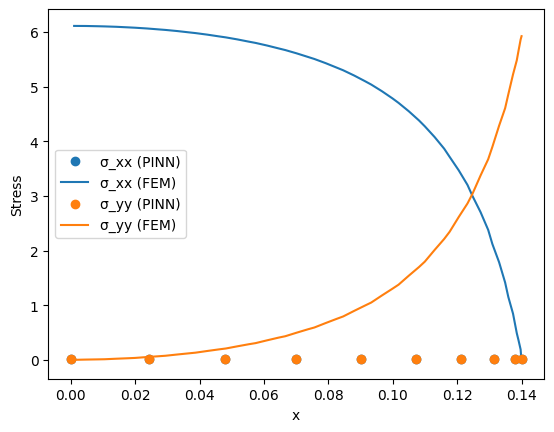

In [ ]:


stress_hole = torch.vmap(sigma)(hole)
data_hole = np.loadtxt(f"data/hole_Rx={Rx}.csv", delimiter=",")
data_hole = data_hole[data_hole[:, 0].argsort()]

stressError = mse(stress_hole[:, 1, 1], torch.tensor(y_stress_y)) + mse(stress_hole[:, 0, 0], torch.tensor(y_stress_x)) 
print("the final x_stress Error is", stressError.item())

with torch.no_grad():
    plt.plot(hole[:, 0], stress_hole[:, 0, 0], "o", color="tab:blue", label="σ_xx (PINN)")
    plt.plot(data_hole[:, 0], data_hole[:, 2], "-", color="tab:blue", label="σ_xx (FEM)")
    plt.plot(hole[:, 0], stress_hole[:, 1, 1], "o", color="tab:orange", label="σ_yy (PINN)")
    plt.plot(data_hole[:, 0], data_hole[:, 3], "-", color="tab:orange", label="σ_yy (FEM)")
    plt.xlabel("x")
    plt.ylabel("Stress")
    plt.legend()
    plt.show()

x_stress_func = np.polyfit(data_hole[:, 0], data_hole[:, 2], 6)
y_stress_func = np.polyfit(data_hole[:, 0], data_hole[:, 3], 6)
f_stress_x = np.poly1d(x_stress_func)
f_stress_y = np.poly1d(y_stress_func)
x_new = np.linspace(data_hole[:, 0][0], data_hole[:, 0][-1], 50)
y_stress_x = f_stress_x(x_new)
y_stress_y = f_stress_y(x_new)

# plt.plot(data_hole[:, 0], data_hole[:, 2],'o', x_new, y_stress_x)
# plt.plot(data_hole[:, 0], data_hole[:, 3],'o', x_new, y_stress_y)
# plt.xlim([data_hole[:, 0][0]-1, data_hole[:, 0][-1] + 1 ])
# plt.show()


In [ ]:
# Create a validation domain different from the training domain
val_x, val_y = np.meshgrid(np.linspace(0, L, 50), np.linspace(0, L, 50))
val_domain = np.vstack([val_x.ravel(), val_y.ravel()]).T
mask = (
    ((val_domain[:, 0] ** 2) / (Rx**2)) + ((val_domain[:, 1] ** 2) / (Ry**2))
) > 1
val = torch.tensor(val_domain[mask], requires_grad=True).double()

# Compute model predictions on the validation domain
disp = net(val)
def_val = val + disp
stress = torch.vmap(sigma)(val)
mises = torch.sqrt(
    stress[:, 0, 0] ** 2
    + stress[:, 1, 1] ** 2
    - stress[:, 0, 0] * stress[:, 1, 1]
    + 3 * stress[:, 0, 1] ** 2
)
# print([loss.item() for loss in compute_les(val)])


@torch.no_grad()
def make_plot(x, y, variable, title, cmap=sequential.Viridis, size=8.0):
    fig = go.Figure()

    # Plot boundaries
    m = dict(color="black")
    fig.add_trace(go.Scatter(x=top[:, 0], y=top[:, 1], mode="lines", marker=m))
    fig.add_trace(go.Scatter(x=bottom[:, 0], y=bottom[:, 1], mode="lines", marker=m))
    fig.add_trace(go.Scatter(x=left[:, 0], y=left[:, 1], mode="lines", marker=m))
    fig.add_trace(go.Scatter(x=right[:, 0], y=right[:, 1], mode="lines", marker=m))
    fig.add_trace(go.Scatter(x=hole[:, 0], y=hole[:, 1], mode="lines", marker=m))

    # Plot variable values
    m = dict(color=variable, colorscale=cmap, size=size, colorbar=dict(thickness=10))
    fig.add_trace(go.Scatter(x=x, y=y, marker=m, mode="markers"))

    # plot settings
    fig.layout.yaxis.scaleanchor = "x"
    fig.update_layout(
        template="none", width=400, height=400, title=title, showlegend=False
    )
    fig.update_xaxes(visible=False)
    fig.update_yaxes(visible=False)
    fig.show()


# Compute data error
s_data = data_output[:, 0:3]
s_pred = torch.vmap(sigma)(data_input[:, 0:2])
ds_xx = s_data[:, 0] - s_pred[:, 0, 0]
ds_yy = s_data[:, 1] - s_pred[:, 1, 1]
ds_xy = s_data[:, 2] - s_pred[:, 0, 1]


# Plot stress errors
cmap = sequential.RdBu_r
make_plot(*data_input[:, 0:2].T, ds_xx, "Stress error xx", size=2.0, cmap=cmap)
make_plot(*data_input[:, 0:2].T, ds_yy, "Stress error yy", size=2.0, cmap=cmap)
make_plot(*data_input[:, 0:2].T, ds_xy, "Stress error xy", size=2.0, cmap=cmap)

# Plot stresses
make_plot(*def_val.T, stress[:, 0, 0], "Stress xx")
make_plot(*def_val.T, stress[:, 0, 1], "Stress xy")
make_plot(*def_val.T, stress[:, 1, 1], "Stress yy")
make_plot(*def_val.T, mises, "Mises stress")

# Plot displacements
make_plot(*def_val.T, disp[:, 0], "Displacement in x", cmap=sequential.Inferno)
make_plot(*def_val.T, disp[:, 1], "Displacement in y", cmap=sequential.Inferno)
